# CNN 

In [2]:
import os
import cv2
import glob
import fnmatch
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import imblearn
import seaborn as sns # Paket za crtanje countplotova(vizuelno predstavljanje klasa kod nebalansiranosti)

In [3]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.optimizers import Adam
from keras.metrics import AUC
from keras import utils

### Učitavanje  podataka

In [4]:
imagePatches = glob.glob('C:/Users/pc/Desktop/data/**/*.png', recursive=True)

In [5]:
patternZero = '*class0.png'
patternOne = '*class1.png'

In [6]:
classZero = fnmatch.filter(imagePatches, patternZero) 
classOne = fnmatch.filter(imagePatches, patternOne)

In [7]:
def load_images(lowerIndex,upperIndex):
    x = []
    y = []
    width = 50
    height = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        image = cv2.imread(img)
        x.append(cv2.resize(image, (width,height), interpolation=cv2.INTER_CUBIC)) # sve slike moraju biti istih dim 
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [8]:
X,y = load_images(0,40000)

In [9]:
X = np.array(X)
y = np.array(y)

### Podela podataka na train, validacioni i test skup

In [10]:
X_train_val,X_test,y_train_val,y_test = model_selection.train_test_split(X, y, test_size = 0.33, random_state = 42, stratify = y)

In [11]:
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42, stratify = y_train_val)

### Normalizacija

In [12]:
X_train = X_train.astype('float32')
X_train = X_train/255

In [13]:
X_val = X_val.astype('float32')
X_val = X_val/255

In [14]:
X_test = X_test.astype('float32')
X_test = X_test/255

### Nebalansiranost train skupa

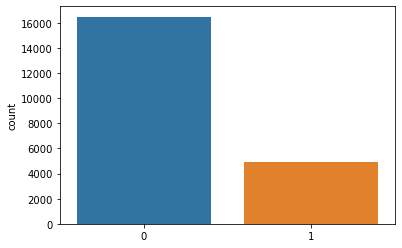

In [15]:
np.bincount(y_train)
sns.countplot(y_train)
plt.show()

In [16]:
X_train.shape

(21440, 50, 50, 3)

In [17]:
np.bincount(y_train)

array([16484,  4956], dtype=int64)

In [18]:
X_val.shape

(5360, 50, 50, 3)

In [19]:
np.bincount(y_val)

array([4121, 1239], dtype=int64)

In [20]:
X_test.shape

(13200, 50, 50, 3)

In [21]:
np.bincount(y_test)

array([10148,  3052], dtype=int64)

### Kreiranje i treniranje mreže 

In [22]:
input_shape = (50,50,3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 1e-5), metrics = [AUC(name = 'auc')])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [23]:
batch_size = 64
epochs = 30
history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_val, y_val))

Epoch 1/30
335/335 [==============================] - 59s 176ms/step - loss: 0.5013 - auc: 0.7428 - val_loss: 0.4630 - val_auc: 0.8587
Epoch 2/30
335/335 [==============================] - 62s 185ms/step - loss: 0.4302 - auc: 0.8573 - val_loss: 0.3955 - val_auc: 0.8758
Epoch 3/30
335/335 [==============================] - 62s 185ms/step - loss: 0.3824 - auc: 0.8697 - val_loss: 0.3657 - val_auc: 0.8810
Epoch 4/30
335/335 [==============================] - 62s 184ms/step - loss: 0.3637 - auc: 0.8756 - val_loss: 0.3553 - val_auc: 0.8832
Epoch 5/30
335/335 [==============================] - 62s 185ms/step - loss: 0.3571 - auc: 0.8784 - val_loss: 0.3509 - val_auc: 0.8854
Epoch 6/30
335/335 [==============================] - 62s 184ms/step - loss: 0.3542 - auc: 0.8795 - val_loss: 0.3557 - val_auc: 0.8869
Epoch 7/30
335/335 [==============================] - 62s 185ms/step - loss: 0.3521 - auc: 0.8808 - val_loss: 0.3469 - val_auc: 0.8877
Epoch 8/30
335/335 [==============================] - 6

In [24]:
model.metrics_names

['loss', 'auc']

In [25]:
def plot(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    
    epochs = history.epoch
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    plt.title('LOSS')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(epochs,loss,c='red',label='training')
    plt.plot(epochs,validation_loss,c='blue',label='validation')
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    
    acc = history.history['auc']
    acc_val = history.history['val_auc']
    plt.title('AUC')
    plt.xlabel('epochs')
    plt.ylabel('AUC')
    plt.plot(epochs,acc,c='red',label='training')
    plt.plot(epochs,acc_val,c='blue',label='validation')
    plt.legend(loc='best')
    
    plt.show()

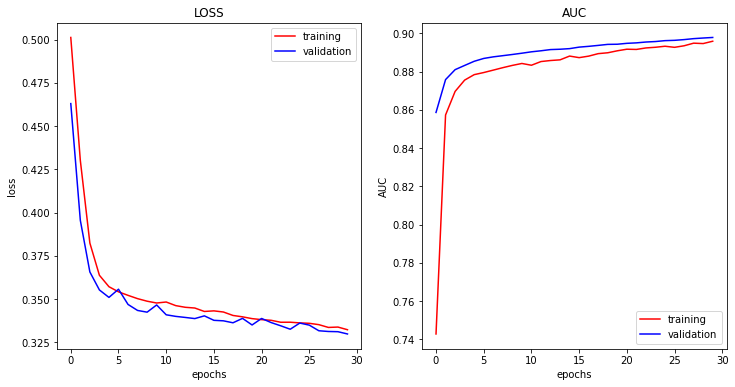

In [26]:
plot(history)

### Evaluacija mreže

In [27]:
X_train_val = X_train_val/255

In [28]:
input_shape = (50,50,3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 1e-5), metrics = [AUC(name = 'auc')])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [29]:
model.fit(X_train_val, y_train_val, epochs = epochs, batch_size = batch_size, verbose = 0)

In [30]:
y_pred_prob = model.predict(X_test)

In [31]:
y_pred = np.zeros(len(X_test))
for i in range(len(X_test)):
    if(y_pred_prob[i]>=0.5):
        y_pred[i] = 1

In [32]:
m = confusion_matrix(y_test,y_pred)
print(m)

[[9225  923]
 [1060 1992]]


In [33]:
r = classification_report(y_test,y_pred)
print(r)

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     10148
           1       0.68      0.65      0.67      3052

    accuracy                           0.85     13200
   macro avg       0.79      0.78      0.79     13200
weighted avg       0.85      0.85      0.85     13200



In [34]:
accuracy = metrics.accuracy_score(y_test,y_pred)
print('accuracy: {:.2f}' .format(accuracy))

accuracy: 0.85


In [35]:
f1 = metrics.f1_score(y_test,y_pred)
print('f1_score: {:.2f}' .format(f1))

f1_score: 0.67


In [36]:
auc_score = metrics.roc_auc_score(y_test,y_pred)
print('auc_score: {:.2f}' .format(auc_score))

auc_score: 0.78
